In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MyStudy/dlwpt-code-ja/p1ch7
%pwd

/content/drive/MyDrive/MyStudy/dlwpt-code-ja/p1ch7


'/content/drive/MyDrive/MyStudy/dlwpt-code-ja/p1ch7'

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

# TorchVision CIFAR10 Dataset

In [ ]:
from torchvision import datasets

data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifer10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 97255391.45it/s] 


Extracting ../data-universioned/p1ch7/cifar-10-python.tar.gz to ../data-universioned/p1ch7/
Files already downloaded and verified


In [ ]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [ ]:
len(cifar10)

50000

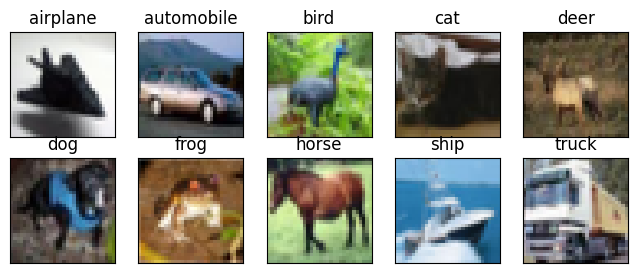

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8, 3))
num_classes = 10

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1+i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

In [ ]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

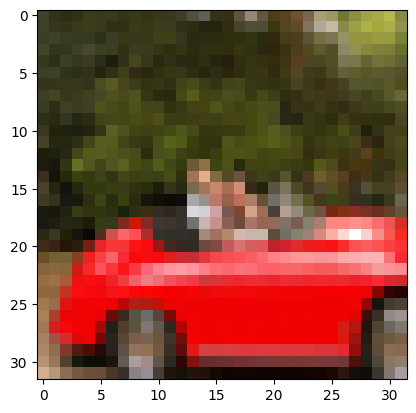

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [ ]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [ ]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [ ]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [ ]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

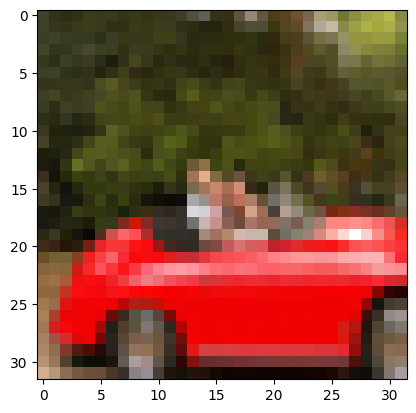

In [ ]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

# 正規化の理由
* データの範囲を一定に保ち、-1\~1(-2\~2)の周りで線形である活性化関数を選択することにより、ニューロンが非ゼロの勾配を持つ可能性を高くし、訓練を高速に実行するため
* 同じ学習率を使用した勾配降下法で、各チャネルの情報を混合および更新できるため

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [ ]:
# Normalize を初期化
transforms.Normalize((0.2470, 0.2435, 0.2616), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.247, 0.2435, 0.2616), std=(0.247, 0.2435, 0.2616))

In [ ]:
transformed_cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.Compose([ # 複数の処理をつなげる
        transforms.ToTensor(),
        transforms.Normalize((0.2470, 0.2435, 0.2616), (0.2470, 0.2435, 0.2616))
    ])
)

In [ ]:
img_t, _ = transformed_cifar10[99]
img_t.shape

torch.Size([3, 32, 32])

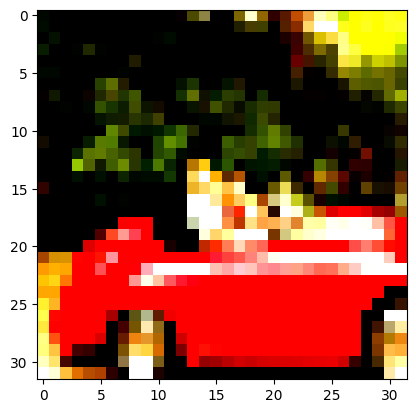

In [ ]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

# 飛行機と鳥を識別するモデルの構築

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [ ]:
%cd /content/drive/MyDrive/MyStudy/dlwpt-code-ja/p1ch7

/content/drive/MyDrive/MyStudy/dlwpt-code-ja/p1ch7


In [ ]:
%pwd

'/content/drive/MyDrive/MyStudy/dlwpt-code-ja/p1ch7'

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [ ]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [ ]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out)
)

In [ ]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [ ]:
x = torch.tensor([1., 2., 3.])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [ ]:
softmax(x).sum()

tensor(1.)

In [ ]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1., 2., 3.], [1., 2., 3.]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [ ]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([512, 3072])
0.bias torch.Size([512])
2.weight torch.Size([2, 512])
2.bias torch.Size([2])


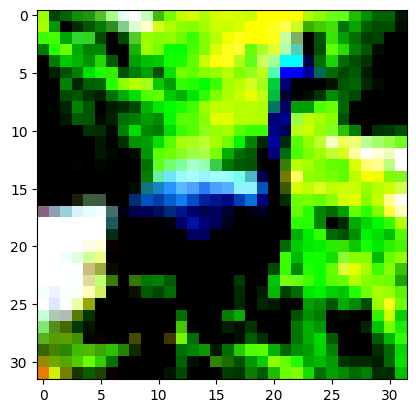

In [ ]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [ ]:
out = model(img_batch)
out

tensor([[0.3981, 0.6019]], grad_fn=<SoftmaxBackward0>)

In [ ]:
_, index = torch.max(out, dim=1)
index

tensor([1])

In [ ]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

In [ ]:
loss = nn.NLLLoss()

In [ ]:
img, label = cifar2[0]
img, label

(tensor([[[ 0.6139, -0.3228,  ..., -0.2752, -0.5451],
          [ 0.6615, -0.1482,  ..., -0.3228, -0.5768],
          ...,
          [ 0.5980,  0.4393,  ..., -0.4340,  0.0265],
          [ 0.9156,  0.8044,  ..., -0.5451, -0.0529]],
 
         [[ 1.3369,  0.2740,  ...,  0.3867,  0.0968],
          [ 1.4497,  0.5961,  ...,  0.3062,  0.0646],
          ...,
          [ 0.5478,  0.6605,  ...,  0.4028,  0.8860],
          [ 0.4834,  0.9504,  ...,  0.1613,  0.7572]],
 
         [[-0.4487, -0.7935,  ..., -0.6736, -0.8535],
          [-0.4487, -0.9734,  ..., -0.6286, -0.8535],
          ...,
          [-0.4337, -0.4787,  ..., -1.3032, -0.9884],
          [-0.1789,  0.0310,  ..., -1.3182, -1.0484]]]),
 1)

In [ ]:
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.7303, grad_fn=<NllLossBackward0>)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(1, n_epochs+1):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch: %d, Loss: %f' % (epoch, float(loss)))

Epoch: 1, Loss: 4.765085
Epoch: 2, Loss: 9.156234
Epoch: 3, Loss: 8.896386
Epoch: 4, Loss: 7.442263
Epoch: 5, Loss: 5.514352
Epoch: 6, Loss: 10.407465
Epoch: 7, Loss: 12.912307
Epoch: 8, Loss: 6.858363
Epoch: 9, Loss: 11.854465
Epoch: 10, Loss: 1.931241
Epoch: 11, Loss: 7.667256
Epoch: 12, Loss: 9.833420
Epoch: 13, Loss: 3.941703
Epoch: 14, Loss: 6.831750
Epoch: 15, Loss: 0.074429
Epoch: 16, Loss: 12.633964
Epoch: 17, Loss: 3.656092
Epoch: 18, Loss: 13.613309
Epoch: 19, Loss: 22.072338
Epoch: 20, Loss: 10.785944
Epoch: 21, Loss: 12.358456
Epoch: 22, Loss: 13.357992
Epoch: 23, Loss: 7.311172
Epoch: 24, Loss: 6.198300
Epoch: 25, Loss: 10.358042
Epoch: 26, Loss: 17.254278
Epoch: 27, Loss: 5.189939
Epoch: 28, Loss: 7.605215
Epoch: 29, Loss: 6.507102
Epoch: 30, Loss: 0.015514
Epoch: 31, Loss: 11.811508
Epoch: 32, Loss: 14.557549
Epoch: 33, Loss: 15.685081
Epoch: 34, Loss: 9.685882
Epoch: 35, Loss: 5.905463
Epoch: 36, Loss: 13.345808
Epoch: 37, Loss: 9.253098
Epoch: 38, Loss: 14.923635
Epoch

# ミニバッチ勾配降下法
* 数個から数百個程度に区切ったデータをランダムに選び、勾配計算とパラメータの更新をすべてのデータについて繰り返し行う.
* torch.utils.data.DataLoeader() によって可能
* メリット
    * 計算量が少ない
    * 学習が収束しやすい

In [ ]:
train_loader = torch.utils.data.DataLoader(
    cifar2, batch_size=64, shuffle=True
)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch %d, Loss: %f' % (epoch, float(loss)))


Epoch 0, Loss: 0.408766
Epoch 1, Loss: 0.302752
Epoch 2, Loss: 0.465233
Epoch 3, Loss: 0.370806
Epoch 4, Loss: 0.186955
Epoch 5, Loss: 0.307516
Epoch 6, Loss: 0.333245
Epoch 7, Loss: 0.575240
Epoch 8, Loss: 0.617705
Epoch 9, Loss: 0.425955
Epoch 10, Loss: 0.314077
Epoch 11, Loss: 0.291352
Epoch 12, Loss: 0.285705
Epoch 13, Loss: 0.604687
Epoch 14, Loss: 0.225688
Epoch 15, Loss: 0.183400
Epoch 16, Loss: 0.206165
Epoch 17, Loss: 0.279199
Epoch 18, Loss: 0.516021
Epoch 19, Loss: 0.193216
Epoch 20, Loss: 0.425349
Epoch 21, Loss: 0.341722
Epoch 22, Loss: 0.253481
Epoch 23, Loss: 0.305132
Epoch 24, Loss: 0.272498
Epoch 25, Loss: 0.285307
Epoch 26, Loss: 0.205136
Epoch 27, Loss: 0.392287
Epoch 28, Loss: 0.112118
Epoch 29, Loss: 0.134051
Epoch 30, Loss: 0.483749
Epoch 31, Loss: 0.298283
Epoch 32, Loss: 0.360192
Epoch 33, Loss: 0.237172
Epoch 34, Loss: 0.122154
Epoch 35, Loss: 0.095486
Epoch 36, Loss: 0.173217
Epoch 37, Loss: 0.069934
Epoch 38, Loss: 0.169233
Epoch 39, Loss: 0.088891
Epoch 40, 

1572864